<a href="https://colab.research.google.com/github/wcjb/Deep-Learning/blob/master/%E5%9F%BA%E7%A1%80%E7%9F%A5%E8%AF%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 环境配置

## 安装Tensorflow2.0的GPU版本

In [0]:
!pip install tensorflow-gpu==2.0.0-beta0 

## 导入相关模块

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from time import time
import numpy as np
from tqdm import tqdm 
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import layers
import platform

# matplotlib绘图属性设置
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12.0, 3.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
%config InlineBackend.figure_format = 'svg'

# pandas显示属性设置
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# 自动微分

### 梯度带(Gradient tapes)

&emsp;&emsp;TensorFlow提供了 tf.GradientTape API 用于自动微分(计算与输入变量相关的计算梯度)。在tf.GradientTape上下文中执行的所有操作“records(记录)”到“tape(磁带)”上。然后，TensorFlow使用该磁带和与每个记录操作相关的梯度，使用反向模式微分“记录”计算的梯度。

---
>
**tf.GradientTape(persistent=False,watch_accessed_variables=True)**:
创建一个新的GradientTape,persistent: 布尔值，用来指定新创建的gradient tape是否是可持续性的。默认是False，意味着只能够调用一次gradient().watch_accessed_variables: 布尔值，表明这个gradien tap是不是会自动追踪任何能被训练（trainable）的变量。默认是True。要是为False的话，意味着你需要手动去指定你想追踪的那些变量。

---
**tf.GradientTape().watch(tensor)**
作用：确保某个tensor被tape追踪

---
**tf.GradientTape().gradient(target,sources,output_gradients=None,unconnected_gradients=tf.UnconnectedGradients.NONE)**：根据tape上面的上下文来计算某个或者某些tensor的梯度,target: 被微分的Tensor或者Tensor列表，你可以理解为经过某个函数之后的值
sources: Tensors 或者Variables列表（当然可以只有一个值）. 你可以理解为函数的某个变量

---
**tf.GradientTape().apply_gradients(grads_and_vars,name=None)**
作用：把计算出来的梯度更新到变量上面去,grads_and_vars: (gradient, variable) 对的列表.
name: 操作名


In [0]:
x = tf.ones((2, 2))
with tf.GradientTape(persistent=False,watch_accessed_variables=True) as t:
    # 使用watch在此上下文管理器上调用方法来手动监视张量
    t.watch(x)
    # 计算张量所有维度的总和
    y = tf.reduce_sum(x)
    z = tf.multiply(y, y)

# 计算张量Z对x的导数
dz_dx = t.gradient(z, x)
dz_dx

<tf.Tensor: id=86, shape=(2, 2), dtype=float32, numpy=
array([[8., 8.],
       [8., 8.]], dtype=float32)>

&emsp;&emsp;默认情况下，GradientTape持有的资源会在调用 GradientTape.gradient() 方法后立即释放。要在同一计算中计算多个梯度，请创建一个持久梯度带，这允许多次调用 gradient() 方法，当磁带对象被垃圾收集时释放资源。

In [0]:
# 初始化Tensor常量
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y
dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = t.gradient(y, x)  # 6.0
print('dz_dx:{},dy_dx:{}'.format(dz_dx,dy_dx))
del t  # Drop the reference to the tape

dz_dx:108.0,dy_dx:6.0


### 记录控制流程

&emsp;&emsp;tapes(磁带)在执行时记录操作，所以Python控制流程（例如使用 if 和 while）自然会被处理

In [0]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:
      output = tf.multiply(output, x)
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)
# 将给定的值转为Tensor
x = tf.convert_to_tensor(2.0)

assert grad(x, 6).numpy() == 12.0
assert grad(x, 5).numpy() == 12.0
assert grad(x, 4).numpy() == 4.0

### 高阶梯度

&emsp;&emsp;GradientTape 上下文管理器内的操作将被记录下来，以便自动微分。如果在该上下文中计算梯度，那么梯度计算也会被记录下来。因此，同样的API也适用于高阶梯度。

In [0]:
# 创建一个Tensor变量，并赋值为1
x = tf.Variable(1.0)  
with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  # Compute the gradient inside the 't' context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0

# 使用自动微分训练回归模型



## 基础理论

+ 张量

&emsp;&emsp;张量是一个多维数组，与NumPy的 ndarray 对象类似，tf.Tensor 对象具有数据类型和形状，此外，tf.Tensor 可以驻留在加速器内存中（如GPU）。TensorFlow提供了丰富的操作库（(tf.add, tf.matmul, tf.linalg.inv 等），它们使用和生成tf.Tensor,这些操作会自动转换本机Python类型。而使用.numpy()方法将张量显式转换为NumPy ndarrays。这些转换通常很便宜，因为如果可能的话，数组和tf.Tensor共享底层的内存表示。但是，共享底层表示并不总是可行的，因为tf.Tensor可以托管在GPU内存中，而NumPy阵列总是由主机内存支持，并且转换涉及从GPU到主机内存的复制。

+ 变量

&emsp;&emsp;TensorFlow中的张量是不可变的无状态对象。然而，机器学习模型需要具有变化的状态：随着模型训练，计算预测的相同代码应该随着时间的推移而表现不同（希望具有较低的损失）。要表示需要在计算过程中进行更改的状态，您可以选择依赖Python是有状态编程语言的这一事实。但是，TensorFlow内置了有状态操作，这些操作通常比您所在状态的低级Python表示更令人愉快。例如，为了表示模型中的权重，使用TensorFlow变量通常是方便有效的。变量是一个存储值的对象，当在TensorFlow计算中使用时，它将隐式地从该存储值中读取。有一些操作（tf.assign_sub, tf.scatter_update等）可以操作存储在TensorFlow变量中的值。
&emsp;&emsp;计算梯度时会自动跟踪使用变量的计算。对于表示嵌入的变量，TensorFlow默认会进行稀疏更新，这样可以提高计算效率和内存效率。
使用变量也是一种快速让代码的读者知道这段状态是可变的方法。

In [0]:
# Using python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In [0]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

# 使用assign()函数更新变量的值
v.assign(3.0)
assert v.numpy() == 3.0

# 可以在assign()中使用函数更新变量的值
v.assign(tf.square(v))
assert v.numpy() == 9.0


## 搭建回归模型

### 定义模型

In [0]:
class LinerDNN(Model):
    def __init__(self):
        super(LinerDNN,self).__init__()
        # 生成服从正态分布的随机值复制给变量
        self.w = tf.Variable(tf.random.normal(shape=[1]),name='w')
        self.b = tf.Variable(tf.random.normal(shape=[1]),name='b')
    # __call__()的作用是使实例能够像函数一样被调用，
    # 同时不影响实例本身的生命周期（__call__()不影
    # 响一个实例的构造和析构）。但是__call__()可以
    # 用来改变实例的内部成员的值。
    def __call__(self, x):
        # 线性模型，不使用激活函数
        return self.w*x + self.b
model = LinerDNN()

### 定义损失函数

In [0]:
@tf.function
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

### 生成训练数据集

In [0]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
# 生成噪声
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

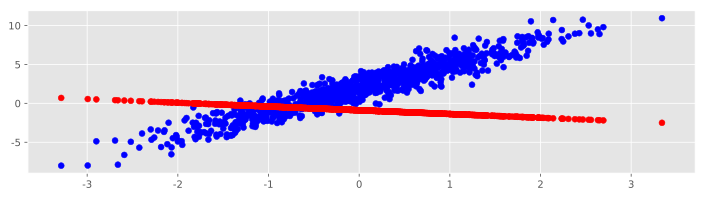

模型的初始误差: 
21.005102


In [0]:
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('模型的初始误差: '),
print(loss(model(inputs), outputs).numpy())

### 定义训练循环

tf.Variable().assign_sub(value)通过减去value得到的新值来更新变量

tf.Variable().assign_add(value)通过加上value得到的新值来更新变量

In [0]:
@tf.function
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.w, model.b])
  model.w.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

### 开始训练

 Epoch    9: w=3.0003 b=2.0019, loss=1.00390 

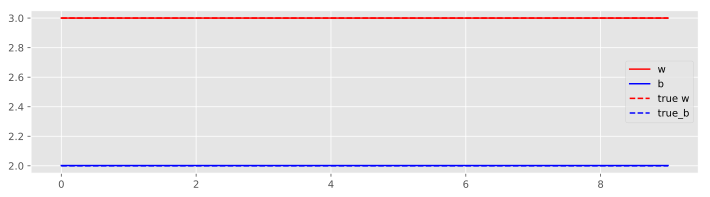

In [0]:
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=0.1)
  print('\r','Epoch %4d: w=%1.4f b=%1.4f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss),flush=True,end=' ')

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
figure = plt.legend(['w', 'b', 'true w', 'true_b'])

### 最小二乘法

In [0]:
def Linear(x,y):
		# 分解长期趋势因子
        assert len(x)==len(y)
        n = len(x)
        D = n*sum(x*x)-sum(x)*sum(x)
        D_x = n*sum(x*y)-sum(x)*sum(y)
        D_y = sum(x*x)*sum(y)-sum(x)*sum(x*y)
        a = D_x/D
        b = D_y/D
        return a,b
w,b = Linear(inputs,outputs)

In [0]:
def RSquare(y_true,y_pre):
        mean  = np.mean(y_true)
        regression = pow(y_true-y_pre,2)
        residual = pow(y_true-mean,2)
        try:
            error = sum(regression)/sum(residual)
        except BaseException as Error:
            error = 0
            print(Error)
        return 1-error

### 比较两种方法的效果

In [0]:
l1 = w*inputs+b
r2_1 = RSquare(l1,outputs)
l2 = Ws[-1]*inputs+bs[-1]
r2_2 = RSquare(l2,outputs)
print('梯度下降法可决系数:{}\n最小二乘法可决系数:{}'.format(r2_1,r2_2))

梯度下降法:0.8923623561859131
最小二乘法:0.8923624753952026


### 使用高阶API

In [0]:
model1 = tf.keras.models.Sequential([
        Dense(units=1, input_dim=1)                            
])
model1.compile(loss='mse',optimizer=tf.optimizers.Adam())
#一个epoch包含的步数（每一步是一个batch的数据送入），当使用如TensorFlow数据
#Tensor之类的输入张量进行训练时，默认的None代表自动分割，即数据集样本数/batch样本数。
#steps_per_epoch指的是在默认小批量为32的条件下，传入相应次数的小批量样本。最终绘制出迭代完成的拟合图像
model1.fit(inputs,outputs,epochs=10,steps_per_epoch=1000)
model1.summary()

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 19.5627
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 11.4140
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 6.4666
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 3.5354
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 1.9244
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2083
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.9980
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.9681
Epoch 9/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.9667
Epoch 10/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.9667
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              P

In [0]:
#CPU是一个有多种功能的优秀领导者。它的优点在于调度、管理、协调能力强，计算能力则位于其次。而GPU相当于一个接受CPU调度的“拥有大量计算能力”的员工。

# 封装使用自动微分求解回归的类

+ Tensorlfow2.0默认搭建动态图，但是静态图比动态图快，可使用装饰器@tf.function生成对应函数的静态图，但是静态图内无法使用动态图函数numpy()

In [0]:
class LDNN(Model):
    def __init__(self):
        super(LDNN,self).__init__()
        # 生成服从正态分布的随机值复制给变量
        self.w = tf.Variable(tf.random.normal(shape=[1]),name='w')
        self.b = tf.Variable(tf.random.normal(shape=[1]),name='b')
    # __call__()的作用是使实例能够像函数一样被调用，
    # 同时不影响实例本身的生命周期（__call__()不影
    # 响一个实例的构造和析构）。但是__call__()可以
    # 用来改变实例的内部成员的值。
    def __call__(self, x):
        # 线性模型，不使用激活函数
        return self.w*x + self.b
    @tf.function
    def LDloss(self,predicted_y, desired_y):
        return tf.reduce_mean(tf.square(predicted_y - desired_y))
    @tf.function
    def LDcompile(self, inputs, outputs, learning_rate):
        with tf.GradientTape() as t:
            current_loss = self.LDloss(self.__call__(inputs), outputs)
        dW, db = t.gradient(current_loss, [self.w, self.b])
        self.w.assign_sub(learning_rate * dW)
        self.b.assign_sub(learning_rate * db)
    #@tf.function
    def LDfit(self,epochs):
        Ws, bs = [], []
        epochs = range(epochs)
        for epoch in epochs:
            Ws.append(self.w.numpy())
            bs.append(self.b.numpy())
            current_loss = loss(self.__call__(inputs), outputs)
            self.LDcompile(inputs, outputs, learning_rate=0.1)
            print('\r','Epoch %4d/200: w=%1.4f b=%1.4f, loss=%2.5f' %
                    (epoch, Ws[-1], bs[-1], current_loss),flush=True,end=' ')

        # Let's plot it all
        plt.plot(epochs, Ws, 'r',
                epochs, bs, 'b')
        plt.plot([TRUE_W] * len(epochs), 'r--',
                [TRUE_b] * len(epochs), 'b--')
        figure = plt.legend(['w', 'b', 'true w', 'true_b'])


 Epoch  199/200: w=3.0323 b=1.9468, loss=0.94822 

1.2523415088653564

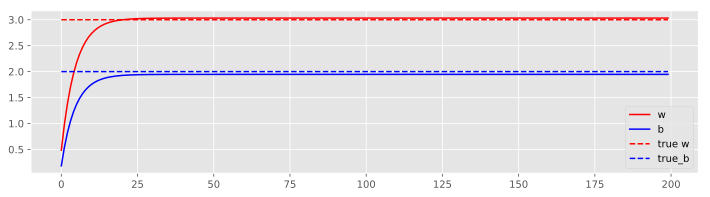

In [0]:
start = time()
model = LDNN()
model.LDcompile(inputs,outputs,0.1)
model.LDfit(200)
time()-start

## 构建时间序列预测模型

In [0]:
df = pd.read_excel('/content/test.xlsx')

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 1 columns):
零售码洋    31 non-null float64
dtypes: float64(1)
memory usage: 328.0 bytes


In [0]:
x = df.values[:12].astype(np.float32)
y = df.values[12:24].astype(np.float32)
volidation = df.values[24:].astype(np.float32)

In [13]:
x

array([[ 5511383.5],
       [ 7110133. ],
       [ 5201458. ],
       [ 5917504.5],
       [ 6094190. ],
       [ 7719451. ],
       [ 8859420. ],
       [ 9638034. ],
       [ 8301782. ],
       [ 8298303.5],
       [ 7445690. ],
       [10698910. ]], dtype=float32)

In [0]:
class LTN(Model):
    def __init__(self):
        super(LTN,self).__init__()
        # 生成服从正态分布的随机值复制给变量
        self.w = tf.Variable(tf.random.normal(shape=[12,1]),name='w1')
        self.b = tf.Variable(tf.random.normal(shape=[12,1]),name='b1')
        self.c = tf.Variable(tf.random.normal(shape=[12,1]),name='c1')
    # __call__()的作用是使实例能够像函数一样被调用，
    # 同时不影响实例本身的生命周期（__call__()不影
    # 响一个实例的构造和析构）。但是__call__()可以
    # 用来改变实例的内部成员的值。
    def __call__(self, x):
        # 线性模型，不使用激活函数
        return tf.nn.relu(tf.multiply(self.w,x) + self.b)+self.c
        
    @tf.function
    def LDloss(self,predicted_y, desired_y):
        return tf.reduce_mean(tf.square(predicted_y - desired_y))
    @tf.function
    def LDcompile(self, inputs, outputs, learning_rate):
        with tf.GradientTape() as t:
            current_loss = self.LDloss(self.__call__(inputs), outputs)
        dW,db,dc = t.gradient(current_loss, [self.w, self.b,self.c])
        self.w.assign_sub(learning_rate * dW)
        self.b.assign_sub(learning_rate * db)
        self.c.assign_sub(learning_rate * dc)
    #@tf.function
    def LDfit(self,epochs):
        Ws,bs,cs = [],[],[]
        epochs = range(epochs)
        for epoch in epochs:
            Ws.append(self.w.numpy())
            bs.append(self.b.numpy())
            cs.append(self.c.numpy())
            current_loss = loss(self.__call__(inputs), outputs)
            self.LDcompile(inputs, outputs, learning_rate=0.1)
            
            print('\r','Epoch %4d/40000:loss=%e' % (epoch,current_loss),flush=True,end=' ')

        return Ws,bs,cs

In [12]:
start = time()
ltn = LTN()
ltn.LDcompile(x,y,0.1)
w,b,c = ltn.LDfit(4000)
time()-start
tf.nn.relu(w[-1]*x+b[-1])+c[-1]

AttributeError: ignored

In [0]:
volidation

array([[11464330.],
       [20153302.],
       [11844526.],
       [12037560.],
       [12998568.],
       [15733129.],
       [19630136.]], dtype=float32)